# Contact Maps

The file `contact_map.py` includes some tricks to study contact maps in protein dynamics, based on tools in MDTraj. This notebook shows examples as serves as documentation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import mdtraj as md
traj = md.load("no-h20.xtc", top="no-h20.pdb")
topology = traj.topology

In [3]:
from contact_map import ContactMap, ContactFrequency, ContactDifference

## Look at a single frame: `ContactMap`

First we make the contact map for the 0th frame. For default parameters (and how to change them) see section "Changing the defaults" below.

In [4]:
%%time
frame_contacts = ContactMap(traj[0])

CPU times: user 78.6 ms, sys: 4.21 ms, total: 82.8 ms
Wall time: 82 ms


CPU times: user 1.07 s, sys: 34.6 ms, total: 1.1 s
Wall time: 1.1 s


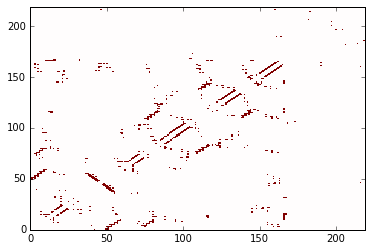

In [5]:
%%time
plt.axis([0, topology.n_residues]*2)
plt.pcolor(frame_contacts.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1);

If you wanted to, you could also plot all the atom-atom contacts. But that takes a lot longer, so it is commented out.

In [6]:
#%time frame_contacts.atom_contacts
#%time df = frame_contacts.atom_contacts.df

In [7]:
#%%time
#plt.axis([0, topology.n_atoms]*2)
#plt.pcolor(df, cmap='RdBu', vmin=-1, vmax=1);

## Look at a trajectory: `ContactFrequency`

`ContactFrequency` finds the fraction of frames where each contact exists.

In [8]:
%%time
trajectory_contacts = ContactFrequency(traj[::100])

CPU times: user 4.45 s, sys: 27.2 ms, total: 4.47 s
Wall time: 4.49 s


In [9]:
# if you want to save this for later analysis
trajectory_contacts.save_to_file("traj_contacts.p")
# then load with ContactFrequency.from_file("traj_contacts.p")

CPU times: user 1.12 s, sys: 26.8 ms, total: 1.15 s
Wall time: 1.15 s


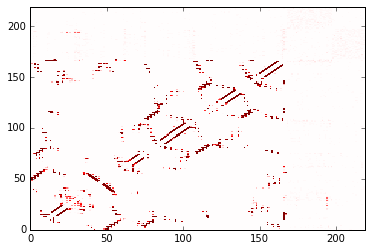

In [10]:
%%time
plt.axis([0, topology.n_residues]*2)
plt.pcolor(trajectory_contacts.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1);

## Compare two: `ContactDifference`

If you want to compare two frequencies, you can use the `ContactDifference` class (or the shortcut for it, which is to subtract a contact frequency/map from another.)

The example below will compare the trajectory to its first frame.

In [11]:
%%time
diff = trajectory_contacts - frame_contacts

CPU times: user 1.32 ms, sys: 647 µs, total: 1.97 ms
Wall time: 1.55 ms


A contact that appears in trajectory, but not in the frame, will be at +1 and will be shown in red below. A contact that appears in the frame, but not the trajectory, will be at -1 and will be shown in blue below. The values are the difference in the frequencies (of course, for a single frame, the frequency is always 0 or 1).

CPU times: user 1.35 s, sys: 44 ms, total: 1.39 s
Wall time: 1.4 s


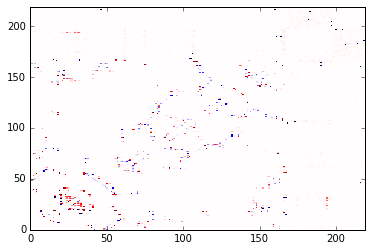

In [12]:
%%time
plt.axis([0, topology.n_residues]*2)
plt.pcolor(diff.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1);

### List the residue contacts that show the most difference

First we look at the frames that are much more important in the trajectory than the frame. Then we look at the frames that are more important in the frame than the trajectory.

The `.most_common()` method gives a list of the contact pairs and the frequency, sorted by frequency. See also `collections.Counter.most_common()` in the standard Python `collections` module.

Here we do this with the `ContactDifference` we created, although it works the same for `ContactFrequency` and `ContactMap` (with the single-frame contact map, the ordering is a bit nonsensical, since every entry is either 0 or 1).

In [13]:
%%time
# residue contact more important in trajectory than in frame (near +1)
diff.residue_contacts.most_common()[:10]

CPU times: user 4.38 ms, sys: 559 µs, total: 4.94 ms
Wall time: 4.87 ms


[([SER17, THR20], 0.9900990099009901),
 ([VAL81, ASN116], 0.9801980198019802),
 ([LEU19, VAL152], 0.9801980198019802),
 ([ALA18, GTP201], 0.9702970297029703),
 ([THR20, LYS16], 0.9603960396039604),
 ([ASP57, MG202], 0.9504950495049505),
 ([ILE163, GLU76], 0.9504950495049505),
 ([GLU162, HIS166], 0.9504950495049505),
 ([THR20, VAL8], 0.9405940594059405),
 ([ASP57, THR20], 0.9405940594059405)]

In [14]:
# residue contact more important in frame than in trajectory (near -1)
list(reversed(diff.residue_contacts.most_common()))[:10]
# alternate: diff.residue_contacts.most_common()[:-10:-1] # (thanks Sander!)

[([CL6864, ASP47], -0.9900990099009901),
 ([VAL29, ILE21], -0.9900990099009901),
 ([GLU162, NA6838], -0.9900990099009901),
 ([LYS165, NA6838], -0.9900990099009901),
 ([NA6816, SER106], -0.9900990099009901),
 ([ARG161, CL6864], -0.9900990099009901),
 ([CL6848, NA6845], -0.9900990099009901),
 ([GLU107, NA6821], -0.9900990099009901),
 ([CL6854, NA6830], -0.9900990099009901),
 ([ASP153, GLN22], -0.9801980198019802)]

### List the atoms contacts most common within a given residue contact

In [15]:
val81 = topology.residue(80)
asn116 = topology.residue(115)
print val81, asn116
gtp201 = topology.residue(166)

VAL81 ASN116


We extended the standard `.most_common()` to take an optional argument. When the argument is given, it will filter the output to only include the ones where that argument is part of the contact. For example, the following gives the residues most commonly in contact with GTP.

In [16]:
for contact in trajectory_contacts.residue_contacts.most_common(gtp201):
    if contact[1] > 0.1:
        print contact

([VAL14, GTP201], 1.0)
([GLY13, GTP201], 1.0)
([ALA146, GTP201], 1.0)
([SER145, GTP201], 1.0)
([GTP201, LEU120], 1.0)
([GTP201, GLY15], 1.0)
([GLY12, GTP201], 1.0)
([ALA11, GTP201], 1.0)
([GTP201, LYS16], 1.0)
([ASN116, GTP201], 1.0)
([LYS147, GTP201], 1.0)
([SER17, GTP201], 1.0)
([LYS117, GTP201], 1.0)
([GTP201, ASP119], 1.0)
([ALA18, GTP201], 0.9702970297029703)
([GTP201, GLU63], 0.5247524752475248)
([ASP57, GTP201], 0.42574257425742573)
([ASP33, GTP201], 0.22772277227722773)
([GTP201, THR144], 0.13861386138613863)


We can also find all the atoms, for all residue contacts, that are in contact with a given residue, and return that sorted by frequency.

In [17]:
diff.most_common_atoms_for_residue(gtp201)[:15]

[([ALA18-CB, GTP201-N7], 0.9702970297029703),
 ([GTP201-O2B, VAL14-CG1], 0.9702970297029703),
 ([GTP201-C8, ALA18-CB], 0.9702970297029703),
 ([SER17-N, GTP201-O2A], 0.9405940594059405),
 ([SER17-C, GTP201-O2A], 0.9405940594059405),
 ([GTP201-O2A, ALA18-CA], 0.9405940594059405),
 ([SER17-CA, GTP201-O2A], 0.9405940594059405),
 ([ALA18-N, GTP201-O2A], 0.9405940594059405),
 ([ALA18-CB, GTP201-O2A], 0.9405940594059405),
 ([SER17-N, GTP201-PB], 0.9306930693069307),
 ([GLY15-C, GTP201-O2A], 0.9306930693069307),
 ([GLY15-O, GTP201-O2A], 0.9108910891089109),
 ([LYS16-N, GTP201-O2A], 0.8811881188118812),
 ([GTP201-C2, LYS147-CB], 0.8514851485148515),
 ([GLY15-C, GTP201-PA], 0.8316831683168316)]

Finally, we can look at which atoms are most commonly in contact within a given residue contact pair.

In [18]:
trajectory_contacts.most_common_atoms_for_contact([val81, asn116])

[([ASN116-CB, VAL81-CG1], 0.9801980198019802),
 ([ASN116-CG, VAL81-CG1], 0.3465346534653465),
 ([VAL81-CG1, ASN116-ND2], 0.2079207920792079),
 ([VAL81-CG1, ASN116-N], 0.13861386138613863),
 ([VAL81-CG1, ASN116-CA], 0.019801980198019802)]

## Changing the defaults

This sections covers several options that you can modify to make the contact maps faster, and to focus on what you're most interested in.

The first three options change which atoms are included as possible contacts. The query atoms are the atoms which appear on the y-axis of the plot. The haystack atoms are those along the x-axis of the plot. In general, you should choose a query that is smaller than the haystack.

Both of these options take a list of atom index numbers. These are most easily created using MDTraj's atom selection language.

In [19]:
# the default selection is
default_selection = topology.select("not water and not symbol == 'H'")
print len(default_selection)

1408


### Using a different query

In [20]:
switch1 = topology.select("resSeq 32 to 38 and not symbol == 'H'")
switch2 = topology.select("resSeq 59 to 67 and not symbol == 'H'")
gtp = topology.select("resname GTP and not symbol == 'H'")
mg = topology.select("element Mg")
cations = topology.select("resname NA or resname MG")
sodium = topology.select("resname NA")

In [21]:
%%time
sw1_contacts = ContactFrequency(trajectory=traj[::100], query=switch1)

CPU times: user 1.82 s, sys: 11.8 ms, total: 1.83 s
Wall time: 1.82 s


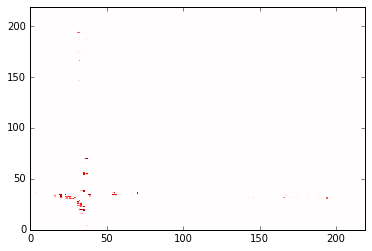

In [22]:
plt.axis([0, topology.n_residues]*2)
plt.pcolor(sw1_contacts.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1);

### Using a different haystack

Currently, changing the haystack has essentially no effect on the performance. However, I expect to change that in the  future (requires making some modifications to MDTraj).

In [23]:
%%time
cations_switch1 = ContactFrequency(trajectory=traj[::100], query=cations, haystack=switch1)

CPU times: user 1.83 s, sys: 16.2 ms, total: 1.84 s
Wall time: 1.87 s


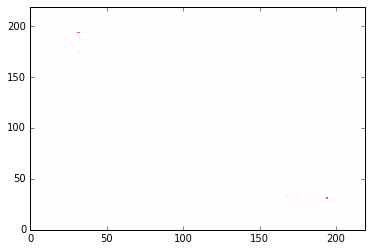

In [24]:
plt.axis([0, topology.n_residues]*2)
plt.pcolor(cations_switch1.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1);

### Changing how many neighboring residues are ignored

By default, we ignore atoms from 2 residues on either side of the given residue (and in the same `chain`). This is easily changed. However, even when you say to ignore no neighbors, you still ignore the residue's interactions with itself.

Note: for non-protein contact, the `chain` is often poorly defined. In this example, the GTP and the Mg are listed sequentially in residue order, and therefore they are considered "neighbors" and their contacts are ignored.

In [25]:
%%time
ignore_none = ContactFrequency(trajectory=traj[::100], n_neighbors_ignored=0)

CPU times: user 6 s, sys: 34.4 ms, total: 6.04 s
Wall time: 6.04 s


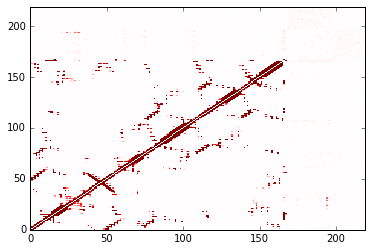

In [26]:
plt.axis([0, topology.n_residues]*2)
plt.pcolor(ignore_none.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1);

### Using a different cutoff

The size of the cutoff has a large effect on the performance. The default is (currently) 0.45nm.

In [27]:
%%time
large_cutoff = ContactFrequency(trajectory=traj[::100], cutoff=1.5)

CPU times: user 2min 19s, sys: 1.78 s, total: 2min 21s
Wall time: 2min 21s


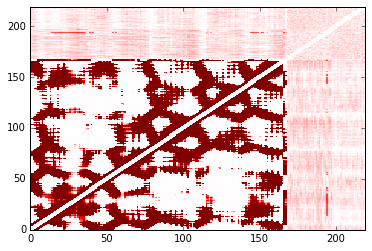

In [28]:
plt.axis([0, topology.n_residues]*2)
plt.pcolor(large_cutoff.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1);